In [4]:
%pip install phonemizer
%pip install inflect

Note: you may need to restart the kernel to use updated packages.

   ------------- -------------------------- 1/3 [more_itertools]
   ---------------------------------------- 3/3 [inflect]

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import numpy as np

# Patch torch.load to always use map_location='cpu'
if not hasattr(torch, "_orig_load"):
    torch._orig_load = torch.load
    def torch_load_cpu(*args, **kwargs):
        kwargs['map_location'] = 'cpu'
        return torch._orig_load(*args, **kwargs)
    torch.load = torch_load_cpu

# Load models
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', map_location='cpu')
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', map_location='cpu')

# Minimal STFT module for Denoiser
class STFT(nn.Module):
    def __init__(self, filter_length=1024, hop_length=256, win_length=1024):
        super().__init__()
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = torch.hann_window(win_length)

    def transform(self, input_data):
        device = input_data.device
        window = self.window.to(device)
        stft = torch.stft(input_data, self.filter_length, self.hop_length, self.win_length, window=window, return_complex=True)
        magnitude = stft.abs()
        phase = stft.angle()
        return magnitude, phase

    def inverse(self, magnitude, phase):
        device = magnitude.device
        window = self.window.to(device)
        stft = torch.polar(magnitude, phase)
        return torch.istft(stft, self.filter_length, self.hop_length, self.win_length, window=window)

# Patch WaveGlow to have .stft for Denoiser compatibility
waveglow.stft = STFT()


class Denoiser(nn.Module):
    def __init__(self, waveglow, filter_length=1024, n_overlap=256, win_length=1024, mode='zeros'):
        super(Denoiser, self).__init__()
        self.stft = waveglow.stft
        if mode == 'zeros':
            mel_input = torch.zeros((1, 80, 88)).to(next(waveglow.parameters()).device)
        elif mode == 'normal':
            mel_input = torch.randn((1, 80, 88)).to(next(waveglow.parameters()).device)
        else:
            raise Exception("Mode {} is not supported".format(mode))
        with torch.no_grad():
            bias_audio = waveglow.infer(mel_input, sigma=0.0)
            bias_spec, _ = self.stft.transform(bias_audio)
        self.register_buffer('bias_spec', bias_spec[:, :, 0][:, :, None])

    def forward(self, audio, strength=0.1):
        audio_spec, audio_angles = self.stft.transform(audio)
        audio_spec_denoised = audio_spec - self.bias_spec * strength
        audio_spec_denoised = torch.clamp(audio_spec_denoised, 0.0)
        audio_denoised = self.stft.inverse(audio_spec_denoised, audio_angles)
        return audio_denoised


# Set to eval and move to CPU
tacotron2 = tacotron2.eval().cpu()
waveglow = waveglow.eval().cpu()
denoiser = Denoiser(waveglow).cpu()

# Use the text_to_sequence function from the loaded Tacotron2 model
def preprocess_text(text):
    sequence = np.array(tacotron2.text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.from_numpy(sequence).cpu().long()
    input_lengths = torch.tensor([sequence.size(1)]).cpu()
    return sequence, input_lengths

Using cache found in C:\Users\User/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\User/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [5]:
import torchaudio
import matplotlib.pyplot as plt
from tacotron2.text import text_to_sequence
from waveglow.denoiser import Denoiser

In [7]:
tacotron2 = tacotron2.eval().cpu()
waveglow = waveglow.eval().cpu()
denoiser = Denoiser(waveglow).cpu()

In [8]:
def preprocess_text(text):
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.from_numpy(sequence).cpu().long()
    input_lengths = torch.tensor([sequence.size(1)]).cpu()
    return sequence, input_lengths

In [9]:
def text_to_speech(text):
    # Preprocess the text
    sequence, input_lengths = preprocess_text(text)

    # Generate mel spectrogram
    with torch.no_grad():
        mel_outputs_postnet, mel,alignments = tacotron2.infer(sequence, input_lengths)

    # Synthesize audio using WaveGlow
    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet)

    # Denoise the audio
    audio = denoiser(audio, strength=0.01)[:, 0]

    return audio, mel_outputs_postnet

In [15]:
text = "This is a TTS-generated speech. I like pizza."
audio, mel = text_to_speech(text)

In [16]:
import IPython.display as ipd
ipd.Audio(audio.cpu().numpy(), rate=22050)

In [17]:
torchaudio.save('output2.wav', audio.cpu(), 22050)

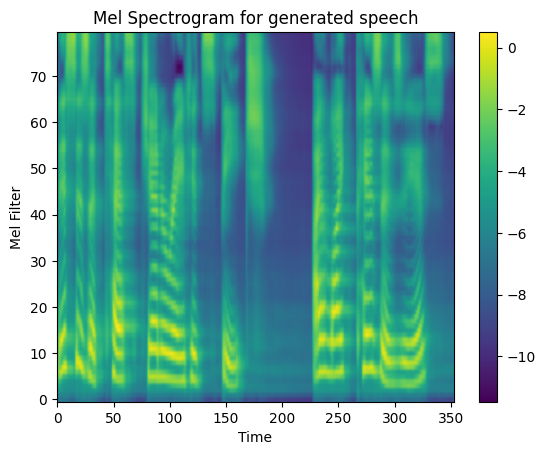

In [18]:
plt.imshow(mel[0].cpu().numpy(), aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Mel Filter')
plt.colorbar()
plt.title('Mel Spectrogram for generated speech')
plt.show()